In [16]:
### Library Imports
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Notes
# In a pairs trading strategy, the positions (long and short) should ideally be taken at the beginning 
# when a trading signal is generated and should remain constant until an exit signal is triggered. The 
# position sizes should not change over time.

### Resources
# https://www.cmcmarkets.com/en/trading-guides/pairs-trading -> Overview of Pairs Trading
# https://hudsonthames.org/an-introduction-to-cointegration/ -> Cointegration for Pairs Trading


In [17]:
### Function to Commodities Data
# List of all commodities available in yfinance
commodities_list = [
    'ES=F', 'YM=F', 'NQ=F', 'RTY=F', 'ZB=F', 'ZN=F', 'ZF=F', 'ZT=F',
    'GC=F', 'MGC=F', 'SI=F', 'SIL=F', 'PL=F', 'HG=F', 'PA=F', 'CL=F',
    'HO=F', 'NG=F', 'RB=F', 'BZ=F', 'B0=F', 'ZC=F', 'ZO=F', 'KE=F',
    'ZR=F', 'ZM=F', 'ZL=F', 'ZS=F', 'GF=F', 'HE=F', 'LE=F', 'CC=F',
    'KC=F', 'CT=F', 'LBS=F', 'OJ=F', 'SB=F'
]
metals = ['GC=F', 'MGC=F', 'SI=F', 'SIL=F', 'PL=F', 'HG=F', 'PA=F']
commodities = ['PL=F', 'PA=F']
energy = ['CL=F', 'HO=F', 'NG=F', 'RB=F', 'BZ=F', 'B0=F']
agriculture = ['ZC=F', 'ZO=F', 'KE=F', 'ZR=F', 'ZM=F', 'ZL=F', 'ZS=F', 'GF=F', 'HE=F', 'LE=F', 'CC=F', 'KC=F', 'CT=F', 'LBS=F', 'OJ=F', 'SB=F']

# Function to import commodities data
def import_commod_data(tickers, start_date, end_date):
    data = pd.DataFrame()
    for t in tickers:
        data[t] = yf.download(t, start=start_date, end=end_date)['Adj Close']
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    return data

# Define commodities and date range
start_date = '2023-07-01'
end_date = '2024-07-01'

# Download data
data = import_commod_data(commodities, start_date, end_date)
print(data.tail())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                   PL=F        PA=F
Date                               
2024-06-24   999.099976  976.099976
2024-06-25   983.700012  933.700012
2024-06-26  1020.700012  922.700012
2024-06-27   991.700012  927.599976
2024-06-28  1001.900024  977.900024


In [18]:
### Function to Compute Spread and Z-Score
def spread_and_zscore(series1, series2):
    spread = series1 - series2
    z_score = (spread - spread.mean()) / spread.std()
    return spread, z_score

### Function Call to Compute Spread and Z-Score
# Define Metals
metal1_data = data[commodities[0]]
metal2_data = data[commodities[1]]
#print(metal1_data)
spread, z_score = spread_and_zscore(metal1_data, metal2_data)
print('Most recent computed spread is: ', round(spread.iloc[-1], 4))
print('Most recent computed z-score is: ', round(z_score.iloc[-1], 4))


Most recent computed spread is:  24.0
Most recent computed z-score is:  1.1919


In [19]:
### Function to check for cointegration
# The cointegration test checks whether there is a long-term equilibrium relationship between the two time series
def check_cointegration(series1, series2):
    result = sm.tsa.stattools.coint(series1, series2)
    p_val = result[1]
    return p_val

### Function Call to Compute P Value
# If the p-value is less than a significance level (commonly 0.05), the null hypothesis of no cointegration is rejected, 
# indicating that the series are cointegrated
p_value = check_cointegration(metal1_data, metal2_data)

if p_value > 0.05:
    print(
        'The computed p-value is:', round(p_value, 4), 
        'and thus the null hypothesis of no cointegration cannot be rejected, \n'
        'so the assumption of mean reversion may not hold and these pairs should NOT be considered'
    )
elif p_value < 0.05:
    print(
        'The computed p-value is:', round(p_value, 4), 
        'and thus the null hypothesis of no cointegration is rejected, \n'
        'so the assumption of mean reversion holds and these pairs should be considered'
    )


The computed p-value is: 0.0365 and thus the null hypothesis of no cointegration is rejected, 
so the assumption of mean reversion holds and these pairs should be considered


In [20]:
### Calculate Trend Signals Based on Z-Score
''' 
The z-score is used to generate trading signals based on predefined thresholds:
  - When the z-score is below -1, it indicates that the spread is significantly below its mean (i.e., one asset 
    is undervalued compared to the other). 
    This means commodity 1 (series1) is cheaper than normal and commodity 2 (series2) is more expensive than normal
    Hence, the strategy goes long on commodity 1 (buying 1000 units) and short on commodity 2 (selling 1000 units)

  - When the z-score is above 1, it indicates that the spread is significantly above its mean (i.e., one asset 
    is overvalued compared to the other). 
    This means commodity 1 (series1) is more expensive than normal and commodity 2 (series2) is cheaper than normal
    Hence, the strategy goes short on commodity 1 (selling 1000 units) and long on commodity 2 (buying 1000 units)
    
  - Positions are exited when the z-score reverts to a value between -0.5 and 0.5, indicating that the spread 
    has reverted to its mean.
'''
# Function to generate trading signals
def generate_signals(data, commodities):
    series1 = data[commodities[0]]
    series2 = data[commodities[1]]
    
    spread, z_score = spread_and_zscore(series1, series2)
    
    longs = z_score < -1
    shorts = z_score > 1
    exits = abs(z_score) < 0.5
    
    signals = pd.DataFrame(index=data.index)
    signals['longs'] = longs
    signals['shorts'] = shorts
    signals['exits'] = exits
    
    return signals, spread, z_score

signals, spread, z_score = generate_signals(data, commodities)



In [21]:
### Function to Calculate the position
def backtest(signals, data, commodities):
    positions = pd.DataFrame(index=signals.index)
    positions[commodities[0]] = 0
    positions[commodities[1]] = 0

    for i in range(len(signals)):
        if signals['longs'].iloc[i]:
            total_value = 1000  # Total value to be invested in each position
            positions.iloc[i] = [total_value / data[commodities[0]].iloc[i], -total_value / data[commodities[1]].iloc[i]]
        elif signals['shorts'].iloc[i]:
            total_value = 1000  # Total value to be invested in each position
            positions.iloc[i] = [-total_value / data[commodities[0]].iloc[i], total_value / data[commodities[1]].iloc[i]]
        elif signals['exits'].iloc[i]:
            positions.iloc[i] = [0, 0]
    
    daily_rets = data.pct_change().dropna()
    returns = (positions.shift(1) * daily_rets).sum(axis=1)
    cumulative_rets = (returns + 1).cumprod() - 1

    return positions, returns, cumulative_rets

positions, returns, cumulative_rets = backtest(signals, data, commodities)
#print(cumulative_rets)


In [22]:
### Function to calculate performance metrics
def calculate_performance_metrics(cumulative_rets, returns):
    total_return = cumulative_rets.iloc[-1]
    annualized_return = (1 + total_return) ** (252 / len(cumulative_rets)) - 1
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
    
    return total_return, annualized_return, sharpe_ratio

total_return, annualized_return, sharpe_ratio = calculate_performance_metrics(cumulative_rets, returns)
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Total Return: 14.45%
Annualized Return: 14.57%
Sharpe Ratio: 0.75


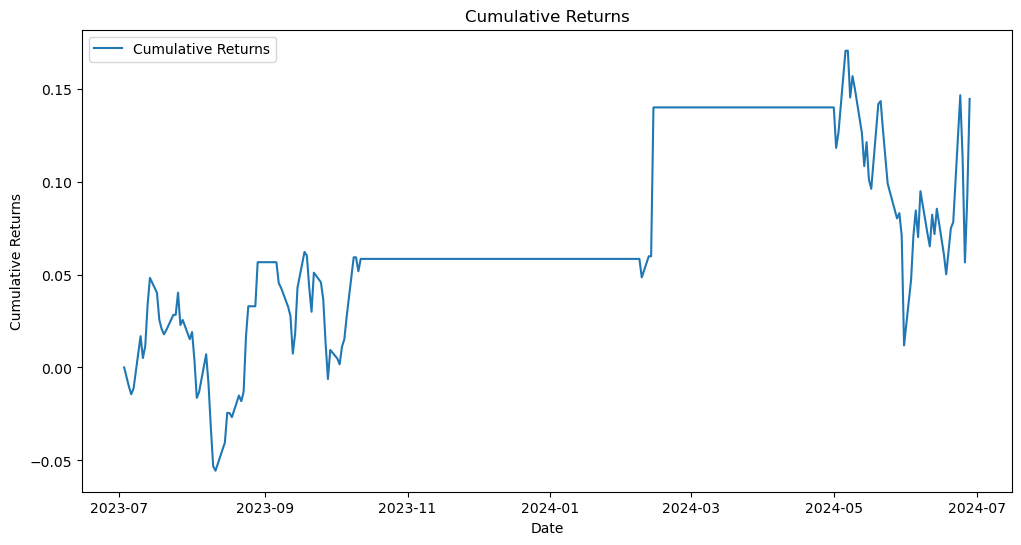

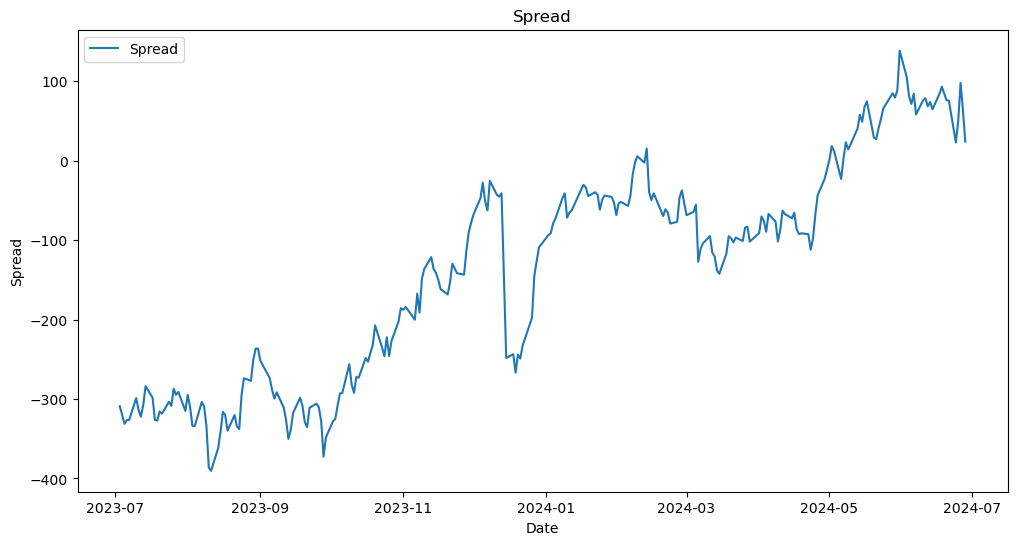

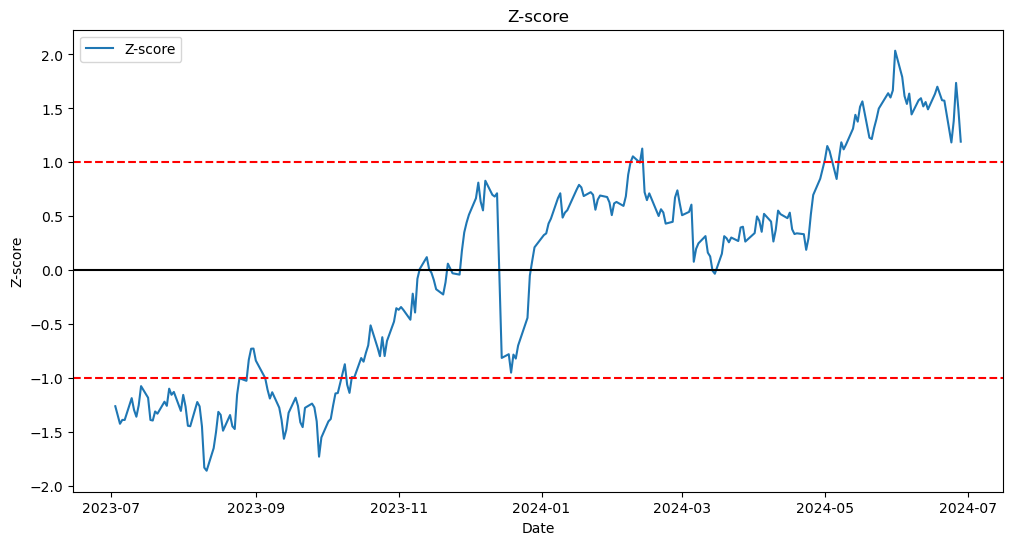

In [23]:
# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_rets, label='Cumulative Returns')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Plot spread
plt.figure(figsize=(12, 6))
plt.plot(spread, label='Spread')
plt.title('Spread')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.show()

# Plot Z-score
plt.figure(figsize=(12, 6))
plt.plot(z_score, label='Z-score')
plt.title('Z-score')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.axhline(1.0, color='r', linestyle='--')
plt.axhline(-1.0, color='r', linestyle='--')
plt.axhline(0.0, color='k', linestyle='-')
plt.legend()
plt.show()
